In [1]:
%pylab inline
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing, cross_validation
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import scipy, scipy.stats, matplotlib
import statsmodels.formula.api as sm
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/Users/vsquared/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
analytic_base = pd.read_csv('~/Repositories/datasets/analytic_base.csv')
analytic_qgiv = pd.read_csv('~/Repositories/datasets/analytic_qgiv_stats.csv')

ab = analytic_base[['id', 'org', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol']]
aq = analytic_qgiv[['id', 'base', 'org', 'total_visits', 'opt_fields', 'req_fields', 'donation_active', 'amounts_system', 'multirestriction_system', 'restrictions', 'pledges_count', 'pledge_active', 'permit_anonymous', 'permit_mobile', 'permit_other_amount', 'enable_donorlogins', 'collect_captcha']]
d = pd.merge(ab, aq, left_on="id", right_on="base")

In [3]:
# filter out not visited observations
data = d[d.visits > 0]
# add conversion
conversion = pd.DataFrame({'conversion':data["don_form_trans_count"]/data["total_visits"]*100})
# merge conversion w/ the rest of the data
data = pd.concat([data, conversion], axis=1)
# add day_of_month & month
date_data = pd.DataFrame({
        'day': pd.to_datetime(data.timestamp).apply(lambda x: x.day), 
        'month': pd.to_datetime(data.timestamp).apply(lambda x: x.month)})
# merge date data w/ the rest of the data
data = pd.concat([data, date_data], axis=1)

# add opt_fields^2, req_fields^2, etc
data['opt_fields2'] = data.opt_fields*data.opt_fields
data['opt_fields3'] = data.opt_fields*data.opt_fields*data.opt_fields
data['req_fields2'] = data.req_fields*data.req_fields
data['req_fields3'] = data.req_fields*data.req_fields*data.req_fields
data['fields'] = data['opt_fields'] + data['req_fields']
data['fields2'] = data['fields']*data['fields']
data['fields3'] = data['fields']*data['fields']*data['fields']

Adding complexity features

* restrictionsXmultirestriction
* restrictions^2
* restrictions^2Xmultirestriction
* restrictions^3
* restrictions^3Xmultirestriction
* opt_fields^2
* opt_fields^3
* req_fields^2
* req_fields^3
* fields
* fields^2
* fields^3

## StatsModels OLS analysis

Take a look at some summary statistics on our data set via StatsModels OLS regression results

In [4]:
features = data.copy()

# remove irrelevant features
to_remove = ['amounts_system', 'id_x', 'org_x', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol', 'id_y', 'base', 'org_y', 'total_visits', 'conversion']
for i_to_remove in to_remove:
    del features[i_to_remove]

# normalize features
features_scaled = preprocessing.scale(features)

In [5]:
data['Eins'] = np.ones((len(data), ))

Y = data.conversion[:-1]
X = features_scaled[:-1]
fit = sm.OLS(Y, X).fit()
print features.columns.values
print fit.summary()

del data['Eins']

['opt_fields' 'req_fields' 'donation_active' 'multirestriction_system'
 'restrictions' 'pledges_count' 'pledge_active' 'permit_anonymous'
 'permit_mobile' 'permit_other_amount' 'enable_donorlogins'
 'collect_captcha' 'day' 'month' 'opt_fields2' 'opt_fields3' 'req_fields2'
 'req_fields3' 'fields' 'fields2' 'fields3']
                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     314.5
Date:                Thu, 26 Jan 2017   Prob (F-statistic):               0.00
Time:                        12:08:49   Log-Likelihood:            -2.3605e+06
No. Observations:              569721   AIC:                         4.721e+06
Df Residuals:                  569701   BIC:                         4.721e+06
Df Model:                          20             

## Evaluating w/out outliers

Copy data and remove outliers. We start with removing specific forms and orgs, then removing higher count field counts.

In [6]:
# copy & remove outliers
data_len = len(data)

nrm_data = data.copy()
# remove outlier orgs & forms
nrm_data = nrm_data[nrm_data.org_x!=27626]
nrm_data = nrm_data[nrm_data.form!=820343]
nrm_data = nrm_data[nrm_data.form!=812122]
nrm_data = nrm_data[nrm_data.form!=711]
nrm_data = nrm_data[nrm_data.form!=87]
# remove higher field counts
nrm_data = nrm_data[nrm_data.req_fields<8]
nrm_data = nrm_data[nrm_data.opt_fields<10]
# remove higher conversion at higher field counts to reshape curve
rm_indexes = (nrm_data.opt_fields > 5) & (nrm_data.conversion > 60)
nrm_data = nrm_data[~rm_indexes]
rm_indexes = (nrm_data.opt_fields > 7) & (nrm_data.conversion > 40)
nrm_data = nrm_data[~rm_indexes]

nrm_data_len = len(nrm_data)

print str(nrm_data_len)+" observations out of "+str(data_len)+" original observations"

558680 observations out of 569722 original observations


We now have the following attributes to the dataframe: 'id_x', 'org_x', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol', 'id_y', 'base', 'org_y', 'total_visits', 'opt_fields', 'req_fields', 'donation_active', 'amounts_system', 'multirestriction_system', 'restrictions', 'pledges_count', 'pledge_active', 'permit_anonymous', 'permit_mobile', 'permit_other_amount', 'enable_donorlogins', 'collect_captcha', 'conversion', 'day', 'month', 'opt_fields2', 'opt_fields3', 'req_fields2', 'req_fields3', 'fields', 'fields2', 'fields3'

Now we  

- copy data set
- remove irrelevant features
- split the data set into a training set and test set
- scale features on the copy of the data set

In [7]:
# rebuild feature matrix
nrm_features = nrm_data.copy()

# remove irrelevant features
to_remove = ['amounts_system', 'id_x', 'org_x', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol', 'id_y', 'base', 'org_y', 'total_visits', 'permit_other_amount', 'day', 'month', 'permit_anonymous', 'donation_active', 'conversion']
for i_to_remove in to_remove:
    del nrm_features[i_to_remove]

# normalize features
nrm_features_scaled = preprocessing.scale(nrm_features)

Now we're left with the following dataframe attributes: 'opt_fields', 'req_fields', 'multirestriction_system', 'restrictions', 'pledges_count', 'pledge_active', 'permit_mobile', 'enable_donorlogins', 'collect_captcha', 'conversion', 'opt_fields2', 'opt_fields3', 'req_fields2', 'req_fields3', 'fields', 'fields2', 'fields3'

### OLS summary

In [8]:
# OLS stats
nrm_data['Eins'] = np.ones((len(nrm_data), ))

Y = nrm_data.conversion[:-1]
X = nrm_features_scaled[:-1]
fit = sm.OLS(Y, X).fit()

print fit.summary()

del nrm_data['Eins']

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     362.5
Date:                Thu, 26 Jan 2017   Prob (F-statistic):               0.00
Time:                        12:08:52   Log-Likelihood:            -2.3115e+06
No. Observations:              558679   AIC:                         4.623e+06
Df Residuals:                  558664   BIC:                         4.623e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1         -7.576e+09   7.61e+10     -0.100      0.9

### Required field model testing

Train the linear regression on conversion rate

In [9]:
X_train, X_test, y_train, y_test = train_test_split(nrm_data.drop(to_remove, axis=1), nrm_data['conversion'], test_size=0.25, random_state=42)

nrm_mdl = linear_model.LinearRegression()
nrm_mdl.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
y_pred = nrm_mdl.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
print "R2: "+str(r2)
print "MSE: "+str(mse)

R2: 0.00879105544379
MSE: 255.329264828


In [11]:
print nrm_mdl.coef_
print nrm_features.columns.values

[  1.48860238e+10   1.48860238e+10   4.27993774e+00   1.94072723e-03
   4.75411415e-02  -3.14709425e-01   4.23643112e-01   8.78210068e-01
   4.14728700e+05  -3.46925735e-01   2.13546753e-02   8.76917839e-02
  -2.86580026e-02  -1.48860238e+10   6.09631538e-02  -1.56974792e-03]
['opt_fields' 'req_fields' 'multirestriction_system' 'restrictions'
 'pledges_count' 'pledge_active' 'permit_mobile' 'enable_donorlogins'
 'collect_captcha' 'opt_fields2' 'opt_fields3' 'req_fields2' 'req_fields3'
 'fields' 'fields2' 'fields3']


Print out some basic stats on our linear regression fit

In [12]:
predictions_test = nrm_mdl.predict(nrm_features[:-100])

rss = np.sum((predictions_test - nrm_data[:-100].conversion) ** 2)
mse = np.mean((predictions_test - nrm_data[:-100].conversion) ** 2)
rmse = np.sqrt(mse)

print "MSE: "+str(mse)
print "RMSE: "+str(rmse)
print "RSS: "+str(rss)

MSE: 225.064410016
RMSE: 15.0021468469
RSS: 125716478.147


Here we are going to calculate the variance of the predictions as a method of validating the trend for the given model. The idea here is that given we cannot reliably predict the true value of the conversion rate with a given model, we are instead going to use the delta as the prediction to proceed with advising upon form changes. Ie, a change in required fields should reliably inform us of the direction and magnitude of the conversion delta, the model being judged by it's variance.

To accomplish this, we use the following:

- iterate through each prediction test
- iterate through the range of potential value changes
- calculate the distance from the mean

In [13]:
data_points = set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
_sigma = []
_mu = []
sample_space = len(predictions_test)
test_observations = nrm_features[:-100].copy()

print "calculating means..."

for n in data_points:
    this_mu = np.mean(nrm_data[nrm_data.req_fields == n].conversion)
    if np.isnan(this_mu):
        this_mu = 0.0
    _mu.append(this_mu)

print "...done calculating means"
print "calculating variance averages..."
print "-------------------------------------------------"

for n in data_points:
    sum_distance_from_mean = 0
    
    test_observations.req_fields = n
    test_observations.req_fields2 = n ** 2
    test_observations.req_fields3 = n ** 3
    test_observations.fields = test_observations.opt_fields + n
    test_observations.fields2 = test_observations.fields ** 2
    test_observations.fields3 = test_observations.fields ** 3

    this_mu = _mu[n]
    predictions = nrm_mdl.predict(test_observations)
    rss_from_mean = (predictions - this_mu) ** 2
    
    del this_mu
    del predictions
    
    this_sigma = np.sum(rss_from_mean) / sample_space
    print " - done with "+str(n)+" sample space, sigma: "+str(this_sigma)
    _sigma.append(this_sigma)
    del this_sigma

print "...done calculating averages"

variance_distance_from_mean = np.mean(_sigma)

print "n: "+str(len(data_points))
print "Average Variance: "+str(variance_distance_from_mean)

calculating means...
...done calculating means
calculating variance averages...
-------------------------------------------------
 - done with 0 sample space, sigma: 2.2057859823
 - done with 1 sample space, sigma: 2.34514318476
 - done with 2 sample space, sigma: 2.49918845367
 - done with 3 sample space, sigma: 2.99541616541
 - done with 4 sample space, sigma: 5.89244408646
 - done with 5 sample space, sigma: 2.78774403778
 - done with 6 sample space, sigma: 2.7539053261
 - done with 7 sample space, sigma: 6.74958978566
 - done with 8 sample space, sigma: 28.3527344377
 - done with 9 sample space, sigma: 88.9336871495
 - done with 10 sample space, sigma: 223.326932833
...done calculating averages
n: 11
Average Variance: 33.5311428584


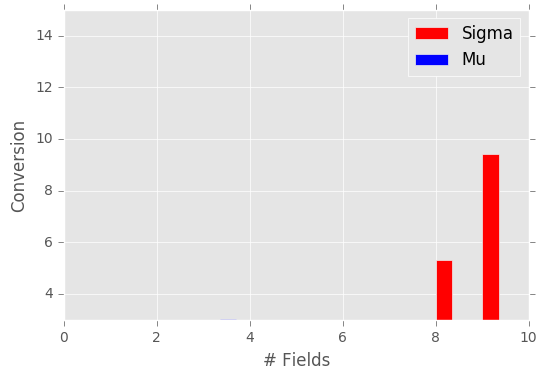

In [14]:
N = np.arange(10)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(N, sqrt(_sigma[0:10]), width, color='r')
rects2 = ax.bar(N+width, _mu[0:10], width, color='b')

ax.set_ylim(3, 15)
ax.set_ylabel("Conversion")
ax.set_xlabel("# Fields")
ax.legend((rects1[0], rects2[0]), ('Sigma', 'Mu'))

plt.show()

In [15]:
term = 'req_fields2'
term[:-1]

'req_fields'

In [16]:
np.sum(np.array([2, 4, 2, 0, 0, 1]) * np.array([0, 0, 0, 2.5, 0.3, 0.002]))

0.002

In [17]:
for k in {'constant':1, 'restrictions':0}:
    print k

restrictions
constant


In [18]:
mydict = {'constant':1, 'restrictions':10}
coef = {'constant':3.2, 'restrictions':0.05}
np.sum([mydict[key]*coef[key] for key in mydict])

3.7000000000000002

In [19]:
term = 'req_fields2'
term[-1] in ['2','3','4','5']

True